# Identifying neighbourhood fingerprints: counterexamples from [Pozdnyakov et al., 2020](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.125.166001)

*Background:*
Geometric GNNs identify local neighbourhoods around nodes via **'neighbourhood finderprints'**, where local geometric information from subsets of neighbours is aggregated to compute invariant scalars. 
The number of neighbours involved in computing the scalars is termed the **body order**.
The ideal neighbourhood fingerprint would perfectly identify neighbourhoods, which requires arbitrarily high body order.

*Experiment:*
To demonstrate the practical implications of scalarisation body order, we evaluate geometric GNN layers on their ability to discriminate counterexamples from [Pozdnyakov et al., 2020](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.125.166001).
Each counterexample consists of a pair of local neighbourhoods that are **indistinguishable** when comparing their set of $k$-body scalars, i.e. geometric GNN layers with body order $k$ cannot distinguish the neighbourhoods.
The 3-body counterexample corresponds to Fig.1(b) in Pozdnyakov et al., 2020, 4-body chiral to Fig.2(e), and 4-body non-chiral to Fig.2(f); the 2-body counterexample is based on the two local neighbourhoods in the running example from our paper.
In this notebook, we train single layer geometric GNNs to distinguish the counterexamples using updated scalar features. 

![Counterexamples from Pozdnyakov et al., 2020](fig/incompleteness.png)

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_undirected
import e3nn
from functools import partial

print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))
print("e3nn version {}".format(e3nn.__version__))

from experiments.utils.plot_utils import plot_3d
from experiments.utils.train_utils import run_experiment
from models import SchNetModel, DimeNetPPModel, SphereNetModel, EGNNModel, GVPGNNModel, TFNModel, MACEModel

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version 1.12.1+cu113
PyG version 2.3.1
e3nn version 0.5.1
Using device: cuda


# Two-body counterexample

Pair of local neighbourhoods that are indistinguishable when comparing their set of $2$-body scalars, i.e. the unordered set of pairwise distances.

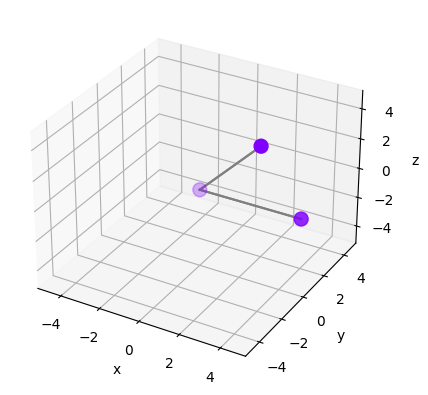

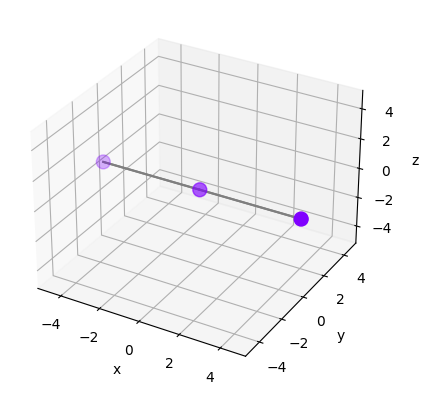

In [3]:
def create_two_body_envs():
    dataset = []

    # Environment 0
    atoms = torch.LongTensor([ 0, 0, 0 ])
    edge_index = torch.LongTensor([ [0, 0], [1, 2] ])
    pos = torch.FloatTensor([ 
        [0, 0, 0],
        [5, 0, 0],
        [3, 0, 4]
    ])
    y = torch.LongTensor([0])  # Label 0
    data1 = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
    data1.edge_index = to_undirected(data1.edge_index)
    dataset.append(data1)
    
    # Environment 1
    atoms = torch.LongTensor([ 0, 0, 0 ])
    edge_index = torch.LongTensor([ [0, 0], [1, 2] ])
    pos = torch.FloatTensor([ 
        [0, 0, 0],
        [5, 0, 0],
        [-5, 0, 0]
    ])
    y = torch.LongTensor([1])  # Label 1
    data2 = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
    data2.edge_index = to_undirected(data2.edge_index)
    dataset.append(data2)
    
    return dataset

# Create dataset
dataset = create_two_body_envs()
for data in dataset:
    plot_3d(data, lim=5)

# Create dataloaders
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset, batch_size=1, shuffle=False)

In [4]:
# Set model
model_name = "mace"

correlation = 2
model = {
    "schnet": SchNetModel,
    "dimenet": DimeNetPPModel,
    "spherenet": SphereNetModel,
    "egnn": EGNNModel,
    "gvp": GVPGNNModel,
    "tfn": TFNModel,
    "mace": partial(MACEModel, correlation=correlation),
}[model_name](num_layers=1, in_dim=1, out_dim=2)

best_val_acc, test_acc, train_time = run_experiment(
    model, 
    dataloader,
    val_loader, 
    test_loader,
    n_epochs=100,
    n_times=10,
    device=device,
    verbose=False
)

Running experiment for MACEModel (cuda).


  0%|          | 0/10 [00:00<?, ?it/s]

/home/pai/lib/python3.9/site-packages/e3nn/o3/_spherical_harmonics.py:92: UserWarning: FALLBACK path has been taken inside: compileCudaFusionGroup. This is an indication that codegen Failed for some reason.
To debug try disable codegen fallback path via setting the env variable `export PYTORCH_NVFUSER_DISABLE=fallback`
To report the issue, try enable logging via setting the envvariable ` export PYTORCH_JIT_LOG_LEVEL=manager.cpp`
 (Triggered internally at  ../torch/csrc/jit/codegen/cuda/manager.cpp:237.)
  sh = _spherical_harmonics(self._lmax, x[..., 0], x[..., 1], x[..., 2])



Done! Averaged over 10 runs: 
 - Training time: 3.23s ± 0.65. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 



# Three-body counterexample

Pair of local neighbourhoods that are indistinguishable when comparing their set of $3$-body scalars, i.e. the unordered set of pairwise distances as well as angles.

In [ ]:
def create_three_body_envs():
    dataset = []

    a_x, a_y, a_z = 5, 0, 5
    b_x, b_y, b_z = 5, 5, 5
    c_x, c_y, c_z = 0, 5, 5
    
    # Environment 0
    atoms = torch.LongTensor([ 0, 0, 0, 0, 0 ])
    edge_index = torch.LongTensor([ [0, 0, 0, 0], [1, 2, 3, 4] ])
    pos = torch.FloatTensor([ 
        [0, 0, 0],
        [a_x, a_y, a_z],
        [+b_x, +b_y, b_z],
        [-b_x, -b_y, b_z],
        [c_x, +c_y, c_z],
    ])
    y = torch.LongTensor([0])  # Label 0
    data1 = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
    data1.edge_index = to_undirected(data1.edge_index)
    dataset.append(data1)
    
    # Environment 1
    atoms = torch.LongTensor([ 0, 0, 0, 0, 0 ])
    edge_index = torch.LongTensor([ [0, 0, 0, 0], [1, 2, 3, 4] ])
    pos = torch.FloatTensor([ 
        [0, 0, 0],
        [a_x, a_y, a_z],
        [+b_x, +b_y, b_z],
        [-b_x, -b_y, b_z],
        [c_x, -c_y, c_z],
    ])
    y = torch.LongTensor([1])  # Label 1
    data2 = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
    data2.edge_index = to_undirected(data2.edge_index)
    dataset.append(data2)
    
    return dataset

# Create dataset
dataset = create_three_body_envs()
for data in dataset:
    plot_3d(data, lim=5)

# Create dataloaders
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset, batch_size=1, shuffle=False)

In [ ]:
# Set model
model_name = "mace"

correlation = 3
model = {
    "schnet": SchNetModel,
    "dimenet": DimeNetPPModel,
    "spherenet": SphereNetModel,
    "egnn": EGNNModel,
    "gvp": GVPGNNModel,
    "tfn": TFNModel,
    "mace": partial(MACEModel, correlation=correlation),
}[model_name](num_layers=1, in_dim=1, out_dim=2)

best_val_acc, test_acc, train_time = run_experiment(
    model, 
    dataloader,
    val_loader, 
    test_loader,
    n_epochs=100,
    n_times=10,
    device=device,
    verbose=False
)

# Four-body non-chiral counterexample

Pair of local neighbourhoods that are indistinguishable when comparing their set of $4$-body scalars without considering chirality/handedness, i.e. the unordered set of pairwise distances, angles, and quadruplet scalars.

In [ ]:
def create_four_body_nonchiral_envs():
    dataset = []

    a1_x, a1_y, a1_z = 3, 2, -4
    a2_x, a2_y, a2_z = 0, 2, 5
    a3_x, a3_y, a3_z = -3, 2, -4
    b1_x, b1_y, b1_z = 3, -2, -4
    b2_x, b2_y, b2_z = 0, -2, 5
    b3_x, b3_y, b3_z = -3, -2, -4
    c_x, c_y, c_z = 0, 5, 0

    angle = 2 * torch.pi / 10 # random angle
    Q = e3nn.o3.matrix_y(torch.tensor(angle)).numpy()

    # Environment 0
    atoms = torch.LongTensor([ 0, 0, 0, 0, 0, 0, 0, 0 ])
    edge_index = torch.LongTensor([ [0, 0, 0, 0, 0, 0, 0], [1, 2, 3, 4, 5, 6, 7] ])
    pos = torch.FloatTensor([ 
        [0, 0, 0],
        [a1_x, a1_y, a1_z],
        [a2_x, a2_y, a2_z],
        [a3_x, a3_y, a3_z],
        [b1_x, b1_y, b1_z] @ Q,
        [b2_x, b2_y, b2_z] @ Q,
        [b3_x, b3_y, b3_z] @ Q,
        [c_x, +c_y, c_z],
    ])
    y = torch.LongTensor([0])  # Label 0
    data1 = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
    data1.edge_index = to_undirected(data1.edge_index)
    dataset.append(data1)
    
    # Environment 1
    atoms = torch.LongTensor([ 0, 0, 0, 0, 0, 0, 0, 0 ])
    edge_index = torch.LongTensor([ [0, 0, 0, 0, 0, 0, 0], [1, 2, 3, 4, 5, 6, 7] ])
    pos = torch.FloatTensor([ 
        [0, 0, 0],
        [a1_x, a1_y, a1_z],
        [a2_x, a2_y, a2_z],
        [a3_x, a3_y, a3_z],
        [b1_x, b1_y, b1_z] @ Q,
        [b2_x, b2_y, b2_z] @ Q,
        [b3_x, b3_y, b3_z] @ Q,
        [c_x, -c_y, c_z],
    ])
    y = torch.LongTensor([1])  # Label 1
    data2 = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
    data2.edge_index = to_undirected(data2.edge_index)
    dataset.append(data2)
    
    return dataset

# Create dataset
dataset = create_four_body_nonchiral_envs()
for data in dataset:
    plot_3d(data, lim=5)

# Create dataloaders
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset, batch_size=1, shuffle=False)

In [ ]:
# Set model
model_name = "mace"

correlation = 4
model = {
    "schnet": SchNetModel,
    "dimenet": DimeNetPPModel,
    "spherenet": SphereNetModel,
    "egnn": EGNNModel,
    "gvp": GVPGNNModel,
    "tfn": TFNModel,
    "mace": partial(MACEModel, correlation=correlation),
}[model_name](num_layers=1, in_dim=1, out_dim=2)

best_val_acc, test_acc, train_time = run_experiment(
    model, 
    dataloader,
    val_loader, 
    test_loader,
    n_epochs=100,
    n_times=10,
    device=device,
    verbose=False
)

# Four-body chiral counterexample

Pair of local neighbourhoods that are indistinguishable when comparing their set of $4$-body scalars when considering chirality/handedness, i.e. the unordered set of pairwise distances, angles, and quadruplet scalars.

In [ ]:
def create_four_body_chiral_envs():
    dataset = []

    a1_x, a1_y, a1_z = 3, 0, -4
    a2_x, a2_y, a2_z = 0, 0, 5
    a3_x, a3_y, a3_z = -3, 0, -4
    c_x, c_y, c_z = 0, 5, 0

    # Environment 0
    atoms = torch.LongTensor([ 0, 0, 0, 0, 0 ])
    edge_index = torch.LongTensor([ [0, 0, 0, 0], [1, 2, 3, 4] ])
    pos = torch.FloatTensor([ 
        [0, 0, 0],
        [a1_x, a1_y, a1_z],
        [a2_x, a2_y, a2_z],
        [a3_x, a3_y, a3_z],
        [c_x, +c_y, c_z],
    ])
    y = torch.LongTensor([0])  # Label 0
    data1 = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
    data1.edge_index = to_undirected(data1.edge_index)
    dataset.append(data1)
    
    # Environment 1
    atoms = torch.LongTensor([ 0, 0, 0, 0, 0 ])
    edge_index = torch.LongTensor([ [0, 0, 0, 0], [1, 2, 3, 4] ])
    pos = torch.FloatTensor([ 
        [0, 0, 0],
        [a1_x, a1_y, a1_z],
        [a2_x, a2_y, a2_z],
        [a3_x, a3_y, a3_z],
        [c_x, -c_y, c_z],
    ])
    y = torch.LongTensor([1])  # Label 1
    data2 = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
    data2.edge_index = to_undirected(data2.edge_index)
    dataset.append(data2)
    
    return dataset

# Create dataset
dataset = create_four_body_chiral_envs()
for data in dataset:
    plot_3d(data, lim=5)

# Create dataloaders
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(dataset, batch_size=2, shuffle=False)

In [ ]:
# Set model
model_name = "tfn"

correlation = 4
model = {
    "schnet": SchNetModel,
    "dimenet": DimeNetPPModel,
    "spherenet": SphereNetModel,
    "egnn": EGNNModel,
    "gvp": GVPGNNModel,
    "tfn": partial(TFNModel, hidden_irreps=e3nn.o3.Irreps(f'64x0e + 64x0o + 64x1e + 64x1o + 64x2e + 64x2o')),
    "mace": partial(MACEModel, correlation=correlation, hidden_irreps=e3nn.o3.Irreps(f'32x0e + 32x0o + 32x1e + 32x1o + 32x2e + 32x2o')),
}[model_name](num_layers=1, in_dim=1, out_dim=2)

best_val_acc, test_acc, train_time = run_experiment(
    model, 
    dataloader,
    val_loader, 
    test_loader,
    n_epochs=100,
    n_times=10,
    device=device,
    verbose=False
)